In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Oliver as o

def from_x_to_matrix(x):
    n = int((-3 + np.sqrt(9+8*x.size))//2)
    k = x.size - n
    A = np.zeros((n, n))
    b = np.zeros(n)
    
    #Insert first k coefficients into matrix
    end = 0
    for j in range(n):
        start = end
        end = start + n-j
        A[j, j:] = x[start:end]
        A[j+1:,j] = A[j, j+1:]
    b = x[-n:] #Insert last n coefficients into vector
    return A, b

# Calculate h for single point z
def hi(x, zi):
    A, b = from_x_to_matrix(x)
    return zi.dot(A.dot(zi)) + b.dot(zi) - 1

# Calculate residual r for single point z
def r(x, zi, wi):
    return np.maximum(wi * hi(x, zi), 0)

#Calculate residual vector
def R(x, Z, W):
    m, n = Z.shape
    R = np.zeros(m)
    for i in range(R.size):
        R[i] = r(x, Z[i], W[i])
    return R

# Calculate objective function
def f(x, Z, W):
    m, n = Z.shape
    return np.sum(R(x, Z, W)**2)

# Calculate gradient oh h for single point z
def dhi(x, zi):
    n = zi.size
    k = n*(n+1)//2
    dh = np.zeros(k+n)
    end = 0
    for j in range(n):
        start = end
        end = start + n-j
        dh[start] = zi[j]**2
        dh[start+1:end] = 2 * zi[j] * zi[start+1:end]
    dh[-n:] = zi
    return dh

# Calculate gradient of residual r for  single point z
# h is the hi value for the given point
def dri(x, zi, wi, ri = None):
    n = zi.size
    dr = np.zeros(x.size)
    if ri == None:
        ri = r(x, zi, wi)
    return (ri > 0) * dhi(x, zi) * wi

# Calculate jacobian of residual vector R
def jacobi(x, Z, W, h = None):
    m, n = Z.shape
    J = np.zeros((m, x.size))
    for i in range(m):
        J[i] = dri(x, Z[i], W[i], h)
    return J

# Calculate gradient of objective function
def df(x, Z, W, h = None):
    return 2 * (jacobi(x, Z, W, h).T).dot(R(x, Z, W))

In [2]:
# x = np.array((1, 0, 0.25, 1, 0))
x = np.array((2, 3, 0.25, 3, 2))
Z = np.array((0, 0, 0, 1, 0, 2, 0, 3, 0, 4)).reshape(5, 2)
# Z = np.array((0,0, 1, 0, 2, 0, 3, 0, 4, 0)).reshape(5, 2)
# Z = np.array((0, 0, 1, 1, 2, 2, 3, 3, 4, 4)).reshape(5,2)
# Z = np.array((2, 0, 2, 1, 2, 2, 2, 3, 2, 4)).reshape(5, 2)
W = np.array((1, 1, 1, 1, 1)) 
print('Z: \n', Z)
print('W: \n', W)
m,n = Z.shape

Z: 
 [[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]]
W: 
 [1 1 1 1 1]


In [3]:
Z = 2 * np.random.randn(5*2).reshape(5,2)
W = np.random.choice([-1.0, 1.0], 5)
x = np.random.randn(5)
print('Z: \n', Z)
print('W: \n', W)
from_x_to_matrix(x)

Z: 
 [[-1.12537148 -1.53093876]
 [ 1.26409113  0.07241121]
 [ 1.19898056 -1.02371318]
 [-2.40896793  1.50787453]
 [-0.51403418  0.28590508]]
W: 
 [ 1. -1.  1.  1.  1.]


(array([[ 1.48966763, -0.94527873],
        [-0.94527873,  0.86518035]]), array([ 0.32679786,  0.2774353 ]))

In [4]:
jacobi(x, Z, W)

array([[ 0.        ,  0.        ,  0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ],
       [ 1.43755439, -2.4548244 ,  1.04798866,  1.19898056, -1.02371318],
       [ 5.80312649, -7.26484277,  2.2736856 , -2.40896793,  1.50787453],
       [ 0.        , -0.        ,  0.        , -0.        ,  0.        ]])

In [5]:
o.jacobi(Z, W, x, n , 2)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.43755439, -2.4548244 ,  1.04798866,  1.19898056, -1.02371318],
       [ 5.80312649, -7.26484277,  2.2736856 , -2.40896793,  1.50787453],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [6]:
dhi(x, Z[2])

array([ 1.43755439, -2.4548244 ,  1.04798866,  1.19898056, -1.02371318])

In [7]:
o.gradr(Z[2], W[2], x, n, 2)

array([ 1.43755439, -2.4548244 ,  1.04798866,  1.19898056, -1.02371318])

In [8]:
R(x, Z, W)

array([  0.        ,   0.        ,   4.47648086,  16.11027121,   0.        ])

In [9]:
o.residuals(Z, W, x, n, 2)

array([  0.        ,   0.        ,   4.47648086,  16.11027121,   0.        ])

In [10]:
df(x, Z, W)

array([ 199.85025264, -256.05512359,   82.64198569,  -66.88382627,
         39.41927039])

In [11]:
o.gradient(Z, W, x, n, 2)

array([ 199.85025264, -256.05512359,   82.64198569,  -66.88382627,
         39.41927039])

In [12]:
r(x, Z[0], W[0])

0.0

In [13]:
hi(x, Z[0])

-1.1353066188319278

In [14]:
R(x, Z, W)

array([  0.        ,   0.        ,   4.47648086,  16.11027121,   0.        ])

In [15]:
f(x, Z, W)

279.57971935269046

In [16]:
df(x, Z, W)

array([ 199.85025264, -256.05512359,   82.64198569,  -66.88382627,
         39.41927039])

In [17]:
from_x_to_matrix(x)

(array([[ 1.48966763, -0.94527873],
        [-0.94527873,  0.86518035]]), array([ 0.32679786,  0.2774353 ]))

In [18]:
Z = 2 * np.random.randn(20*2).reshape(20,2)
W = np.random.choice([-1.0, 1.0], 20)

m, n = Z.shape
k = n*(n+1)//2

x = np.random.randn(n+k)
p = np.random.randn(n+k)
p = p/np.linalg.norm(p)
f0 = f(x, Z, W)
g = df(x, Z, W).dot(p)
if g == 0:
    print("p: \n", p)
    print(df(x, Z, W))
    
else:
    print("g = %e" %g)
    for ep in 10.0**np.arange(2, -9, -1):
        g_app = (f(x+ep*p, Z, W)-f0)/ep
        error = abs(g_app-g)/abs(g)
        print('ep = %e, error = %e, g_app = %e' % (ep,error, g_app))

g = 3.193291e+00
ep = 1.000000e+02, error = 6.651234e+03, g_app = 2.124252e+04
ep = 1.000000e+01, error = 6.676848e+02, g_app = 2.135305e+03
ep = 1.000000e+00, error = 6.395851e+01, g_app = 2.074314e+02
ep = 1.000000e-01, error = 6.395851e+00, g_app = 2.361710e+01
ep = 1.000000e-02, error = 6.395851e-01, g_app = 5.235672e+00
ep = 1.000000e-03, error = 6.395851e-02, g_app = 3.397529e+00
ep = 1.000000e-04, error = 6.395851e-03, g_app = 3.213714e+00
ep = 1.000000e-05, error = 6.395836e-04, g_app = 3.195333e+00
ep = 1.000000e-06, error = 6.395000e-05, g_app = 3.193495e+00
ep = 1.000000e-07, error = 6.524330e-06, g_app = 3.193311e+00
ep = 1.000000e-08, error = 1.540080e-06, g_app = 3.193296e+00


## Implementation 

In [19]:
def backtracking_line_search(f, gradf, p, x, Z, W):
    ρ = 0.5
    c = 0.05
    α = 0.5
    
    ϕₖ = f(x + α * p, Z, W)
    dF = gradf(x, Z, W)
    it = 0
    while (ϕₖ >= f(x, Z, W) + c * α * dF.dot(p) and it < 200):
        α = ρ * α
        ϕₖ = f(x + α * p, Z, W)
        it += 1
#     print(it)
    return α

In [20]:
def steepest_descent(f, grad, x0, Z, W, tol = 1e-3):
    p = -df(x0, Z, W)
    xₖ = x0
    it = 0
    while np.linalg.norm(p) > tol and it < 5000:
        α = backtracking_line_search(f, grad, p, xₖ, Z, W)
#         print(α)
#         print(xₖ)
#         print("f(x) =", f(xₖ, Z, W))#, "df(x) =" , df(xₖ, Z ,W))

        xₖ = xₖ + α * p
        p = -df(xₖ, Z, W)
        it += 1
        if it % 500 == 0:
            print(it)
            print(α)
            print("f(x) =", f(xₖ, Z, W))
    print("f(x) =", f(xₖ, Z, W), "df(x) =" , df(xₖ, Z ,W))

    return xₖ, it

In [21]:
def H(X, A, b):
    return ((X @ A) * X).sum(axis = 1) + (b * X).sum(axis = 1) - 1

f(x) = 1.39567620685e-06 df(x) = [ -2.66212470e-05   1.51916600e-04  -6.79460924e-04   1.23241414e-04
   6.42061073e-04]


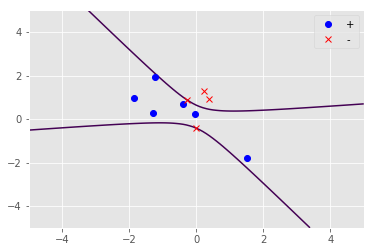

R: 
 [ 0.          0.          0.          0.00018552  0.          0.          0.
  0.          0.          0.00116673]
df: 
 [ -2.66212470e-05   1.51916600e-04  -6.79460924e-04   1.23241414e-04
   6.42061073e-04]
f: 
 1.39567620685e-06
Z: 
 [[ 0.23105326  1.28417573]
 [-0.02746037  0.24882008]
 [-1.24327986  1.95053478]
 [-0.26657496  0.86962482]
 [-1.85996203  0.95973238]
 [ 1.52253546 -1.80268061]
 [-0.39984086  0.71441444]
 [ 0.39147202  0.94453142]
 [-1.28031791  0.27311683]
 [-0.01042613 -0.41343567]]


In [34]:
m, n = (10, 2)

Z = np.random.randn(m*n).reshape(m, n)
W = np.random.choice([-1.0, 1.0], m)
x = np.array((1,0,1,0,0))
#x = np.random.randn(5)
# x[0] = 5
# x[3] = 6

a = steepest_descent(f, df, x, Z, W)[0]
A, b = from_x_to_matrix(a)

x = np.linspace(-5, 5, 101)
y = np.linspace(-5, 5, 101)
xx, yy = np.meshgrid(x, y)
X = np.stack((xx.flatten(), yy.flatten())).T

A, b = from_x_to_matrix(a)
plt.figure()
plt.contour(yy, xx, H(X, A, b).reshape(xx.shape).T, levels = [0])

plt.plot(Z[W==1, 0], Z[W==1,1], 'o', color = 'b', label = "+")
plt.plot(Z[W==-1, 0], Z[W==-1,1], 'x', color = 'r', label = "-")
plt.legend()


plt.show()
print("R: \n", R(a, Z, W))
print("df: \n", df(a, Z, W))
print("f: \n",f(a, Z, W))
print("Z: \n", Z)